In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from heatmap import generate_heatmap

In [2]:
image_path = './images/Cookie_theft_segmentation.png'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use a KD-Tree to find unique colors within a threshold
threshold = 5
tree = cKDTree(pixels)
unique_colors = []
labels = np.zeros(pixels.shape[0], dtype=int) - 1

for i, pixel in enumerate(pixels):
    if labels[i] == -1:
        indices = tree.query_ball_point(pixel, threshold)
        unique_colors.append(pixel)
        labels[indices] = len(unique_colors) - 1

unique_colors = np.array(unique_colors)

# Print unique colors
print(f"Unique colors (within threshold): {unique_colors}")

Unique colors (within threshold): [[  0   0   0]
 [255   0   0]
 [  0   0 255]
 [128   0   0]
 [255 255   0]
 [  0 255 255]
 [128 128   0]
 [255   0 255]
 [  0   0 128]
 [  0 255   0]
 [  0 128   0]]


In [3]:
# Create a dictionary mapping from color tuples to segment labels
color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# Print the mapping
print(f"Color to label mapping: {color_to_label}")


Color to label mapping: {(0, 0, 0): 0, (255, 0, 0): 1, (0, 0, 255): 2, (128, 0, 0): 3, (255, 255, 0): 4, (0, 255, 255): 5, (128, 128, 0): 6, (255, 0, 255): 7, (0, 0, 128): 8, (0, 255, 0): 9, (0, 128, 0): 10}


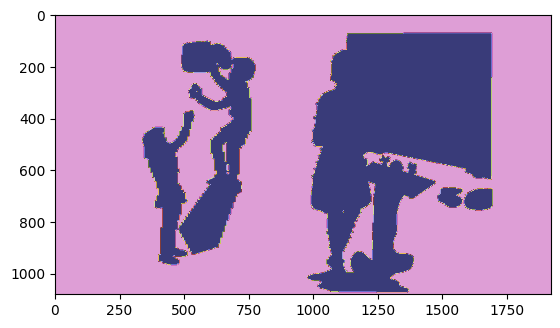

0


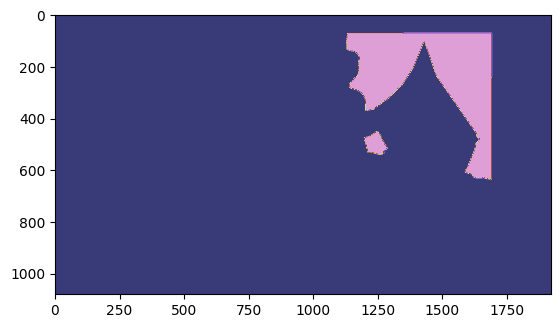

1


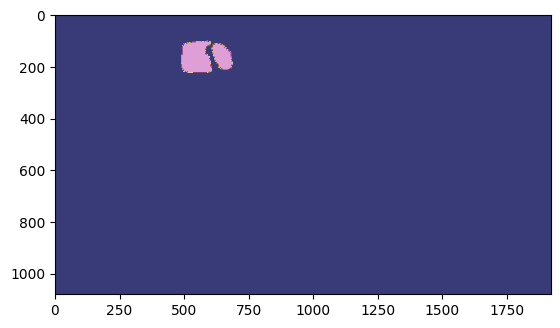

2


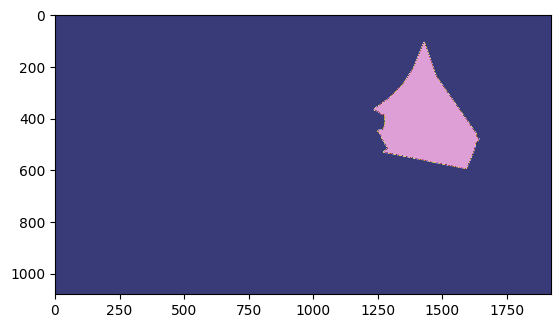

3


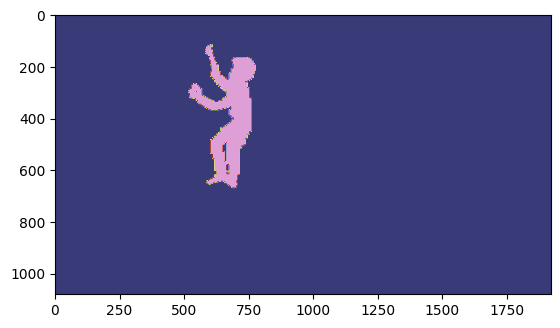

4


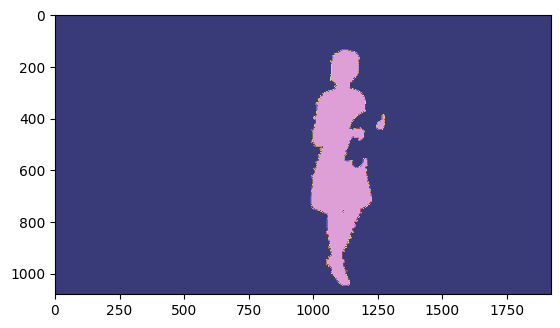

5


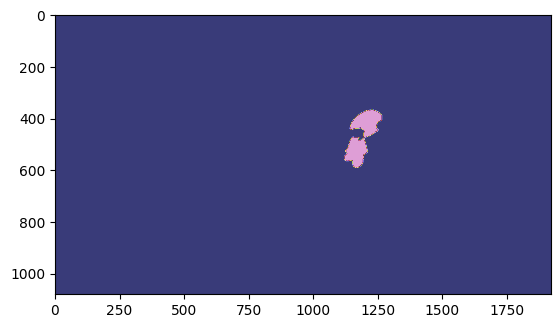

6


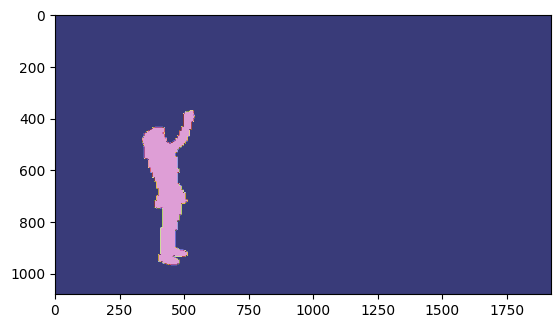

7


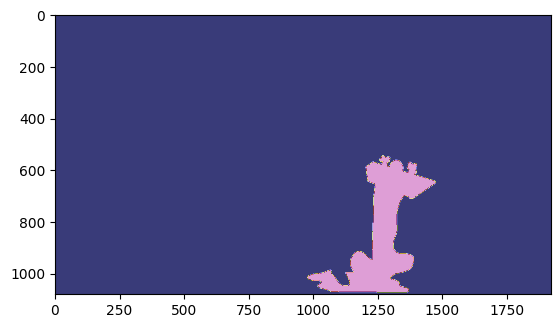

8


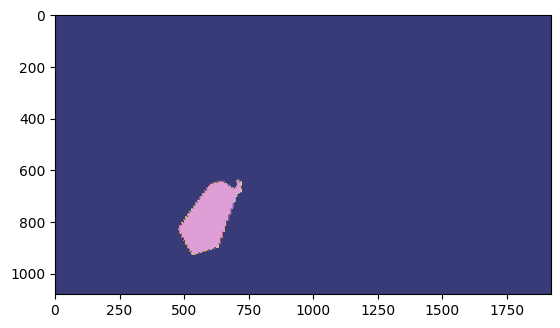

9


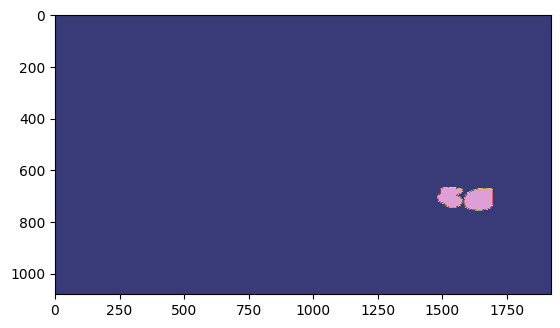

10
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# Initialize the segmented mask with the same height and width as the input image
segmented_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.int32)

# Assign labels to each pixel based on the color
for i, color in enumerate(unique_colors):
    mask = np.all(image_rgb==color, axis=-1)
    plt.imshow(mask, cmap='tab20b')
    plt.show()
    print(i)
    segmented_mask[mask] = i

# Print the segmented mask
print(segmented_mask)


In [5]:
# for id in mask_id_list:
#     isolated_mask = segmented_mask.copy()
#     isolated_mask[isolated_mask != id] = -1
#     print(f"id: {id}, tag: {image_component_id_lookup[id]}")
#     print(np.unique(isolated_mask))
#     seperated_masks[id] = isolated_mask
#     plt.imshow(seperated_masks[id], cmap='nipy_spectral')
#     plt.colorbar()
#     plt.show()

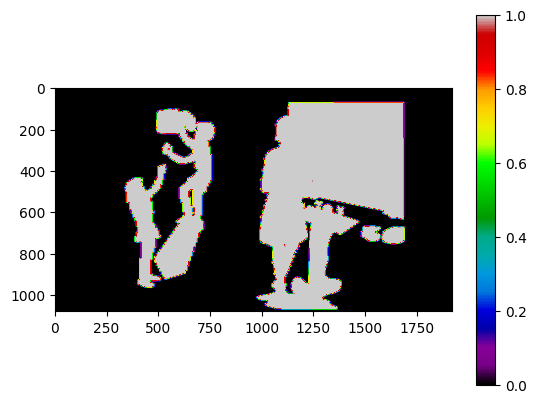

In [6]:
image_component_mask = segmented_mask.copy().astype(float)
image_component_mask[image_component_mask != 0] = 1.0 # Put 1 here so it is normalized
plt.imshow(image_component_mask, cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [7]:
# Make 0 values transparent in heatmap
hot_cmap = plt.get_cmap('plasma')  # Get the original 'hot' colormap
hot_colors = hot_cmap(np.arange(hot_cmap.N))  # Get the colormap colors
hot_colors[:, -1] = np.linspace(0, 1, hot_cmap.N)  # Modify alpha values
hot_cmap_with_alpha = LinearSegmentedColormap.from_list('hot_alpha', hot_colors)

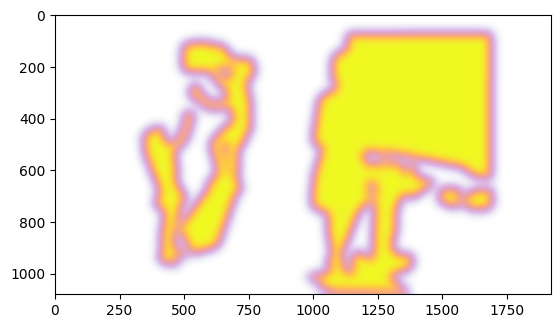

In [8]:
sigma = 20
baseline = gaussian_filter(image_component_mask, sigma=sigma)
plt.imshow(baseline, cmap=hot_cmap_with_alpha, alpha=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


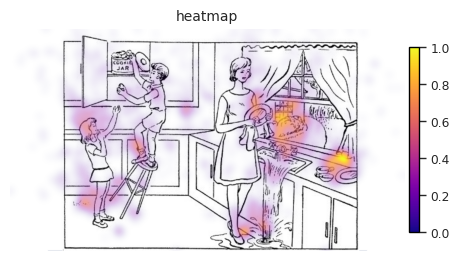

In [9]:
p23_s1_distribution = generate_heatmap("./data/P23_S1_all_gaze.csv", sigma=sigma, is_saving=False, height=1080, width=1920)

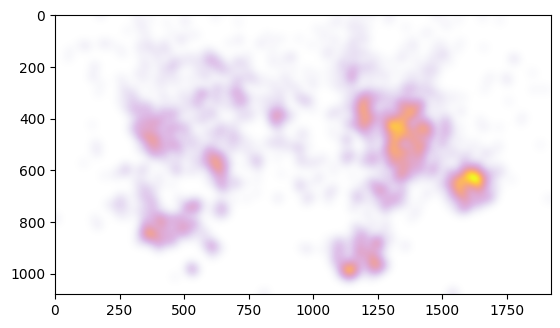

In [10]:
plt.imshow(p23_s1_distribution, cmap=hot_cmap_with_alpha, alpha=1)

In [11]:
p23_s1_distribution.shape

(1080, 1920)

In [12]:
baseline.shape

(1080, 1920)

In [13]:
baseline

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## MSE

In [14]:
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

similarity_score = mse(baseline, p23_s1_distribution)
print("Mean Squared Error:", similarity_score)


Mean Squared Error: 0.19650831562773202


## Structural Similarity Index 

In [15]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(image1, image2):
    score, _ = ssim(image1, image2, full=True, data_range=1.0)
    return score

similarity_score = compute_ssim(baseline, p23_s1_distribution)
print("SSIM:", similarity_score)


SSIM: 0.46679432532794196


## Normalized Cross-Correlation

In [ ]:
from scipy.signal import correlate2d

def normalized_cross_correlation(image1, image2):
    image1 = (image1 - np.mean(image1)) / (np.std(image1) * len(image1))
    image2 = (image2 - np.mean(image2)) / np.std(image2)
    return correlate2d(image1, image2, mode='same').max()

similarity_score = normalized_cross_correlation(baseline, p23_s1_distribution)
print("Normalized Cross-Correlation:", similarity_score)


## Historgram Comparison

In [ ]:
from scipy.stats import entropy

def compare_histograms(image1, image2, bins=256):
    hist1, _ = np.histogram(image1, bins=bins, range=(0, 1), density=True)
    hist2, _ = np.histogram(image2, bins=bins, range=(0, 1), density=True)
    return entropy(hist1, hist2)

similarity_score = compare_histograms(baseline, p23_s1_distribution)
print("Histogram KL Divergence:", similarity_score)
